In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import cactas as C
import os
import mahotas as mh
import nibabel as nib
import nrrd
import skimage.morphology
import cv2
from skimage.filters import threshold_otsu

In [3]:
DATAPATH='/raid/mpsych/CACTAS/DATA/ESUS'

In [4]:
images, labels = C.Helper.load_data(DATAPATH)

In [5]:
X_train, y_train, X_test, y_test = C.Helper.split_patients(images, labels)

In [7]:
X_train[15]

'62.img.nrrd'

In [8]:
TS_PATH='TS'

In [9]:
segment_62_l = TS_PATH + "/62/common_carotid_artery_left.nii.gz"
segment_62_r = TS_PATH + "/62/common_carotid_artery_right.nii.gz"
img_62_l = nib.load(segment_62_l)
img_62_r = nib.load(segment_62_r)
data_62_l = img_62_l.get_fdata()
data_62_r = img_62_r.get_fdata()

In [10]:
combined = data_62_l + data_62_r

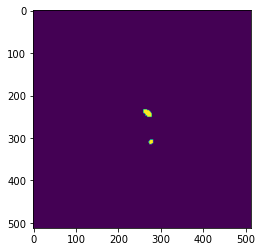

In [11]:
plt.imshow(combined[:,:,54])
plt.show()

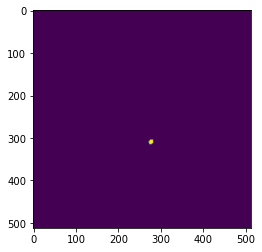

In [12]:
plt.imshow(data_62_l[:,:,54])
plt.show()

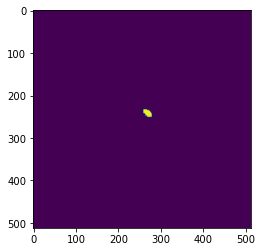

In [13]:
plt.imshow(data_62_r[:,:,54])
plt.show()

In [14]:
combined.shape

(512, 512, 268)

In [15]:
from skimage.filters import threshold_otsu

In [16]:
# setting filter to the image
img = combined[:, :, 54]
# otsu method
T_otsu = threshold_otsu(img)
  
# image values should be greater than otsu value
img = img > T_otsu

es = np.ones((50, 50), bool)


# dilating image
dilate_img = mh.morph.dilate(img,es)
bbox = mh.bbox(dilate_img)
print(bbox)

[208 339 234 306]


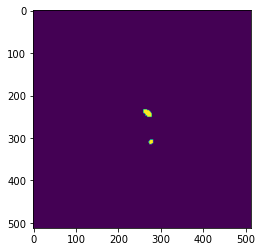

In [17]:
plt.imshow(img)
plt.show()

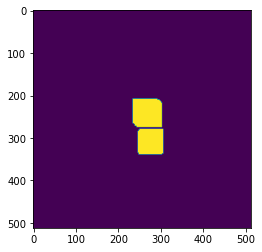

In [18]:
plt.imshow(dilate_img)
plt.show()

In [19]:
images=[]
for i in range(combined.shape[2]):
    # setting filter to the image
    img = combined[:, :, i]
    # otsu method
    T_otsu = threshold_otsu(img)
    # image values should be greater than otsu value
    img = img > T_otsu
    es = np.ones((50, 50), bool)
    # dilating image
    dilate_img = mh.morph.dilate(img,es)
    images.append(dilate_img)

In [20]:
#for i in range(len(images)):
#    plt.imshow(images[i])
#    plt.show()

In [21]:
label, header = nrrd.read(DATAPATH + "/" + y_train[15])

In [22]:
bbox_plaque = mh.bbox(label)

In [23]:
bbox_plaque

array([221, 345, 233, 251, 109, 123])

In [24]:
bbox_combined = mh.bbox(combined)

In [25]:
bbox_combined

array([213, 324, 242, 291,  30, 105])

In [26]:
bbox_combined[4], bbox_plaque[5]

(30, 123)

In [27]:
minimum = min(bbox_combined[4],bbox_plaque[4])
maximum = max(bbox_combined[5],bbox_plaque[5])

In [28]:
minimum, maximum

(30, 123)

In [30]:
images=[]

for i in range(combined.shape[2]):
    img = combined[:, :, i]
    T_otsu = threshold_otsu(img)
    img = img > T_otsu
    es = np.ones((50, 50), bool)
    dilate_img = mh.morph.dilate(img,es)
    bbox = mh.bbox(dilate_img)
    #print(i, bbox)
    
    if i >= minimum and i <= maximum+1:
        if np.all(bbox == 0):
            bbox = [min(bbox_combined[0],bbox_plaque[0]),
                    max(bbox_combined[1],bbox_plaque[1]),
                    min(bbox_combined[2],bbox_plaque[2]),
                    max(bbox_combined[3],bbox_plaque[3])]
            dilate_img[bbox[0]:bbox[1], bbox[2]:bbox[3]] = 1
        
    #print(i, bbox)
    images.append(dilate_img)


In [31]:
len(images)

268

In [ ]:
#for i in range(len(images)):
#    plt.imshow(images[i])
#    plt.show()

In [32]:
binary_mask=[]
for i in range(len(images)):
    binary = (images[i] > 0).astype(np.uint8) * 255
    binary_mask.append(binary)

In [33]:
image, header = nrrd.read(DATAPATH + "/" + X_train[15])

In [34]:
label, header = nrrd.read(DATAPATH + "/" + y_train[15])

In [35]:
image_patient=[]
for i in range(image.shape[2]):
    img = image[:,:,i]
    image_patient.append(img)

In [36]:
results=[]
for i in range(len(image_patient)):
    result = image_patient[i] * binary_mask[i]
    results.append(result)

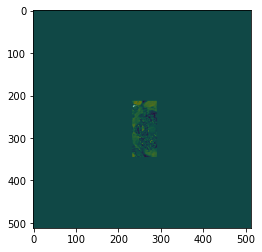

In [37]:
plt.imshow(results[115])
plt.imshow(label[:,:,115], cmap='gray', alpha=0.5)
plt.show()

In [1]:
#for i in range(image.shape[2]):
#    plt.imshow(results[i])
#    plt.imshow(label[:,:,i], cmap='gray', alpha=0.5)
#    plt.show()